In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from collections import deque
import anndata
from scipy.stats import fisher_exact

In [2]:
# def cal_clust_silhouette(adata, n_pcs, resolution):
#     tmp_adata = sc.pp.neighbors(adata, n_pcs=n_pcs, copy=True)
#     sc.tl.umap(tmp_adata)
#     sc.tl.leiden(tmp_adata, key_added="leiden_res", resolution=resolution)
#     return silhouette_score(tmp_adata.X, tmp_adata.obs['leiden_res'])

# Preprocess

## read data

In [2]:
aae_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20250318_replot_mosq/aae/1.QC.h5ad'
aae_bl_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20250318_replot_mosq/aae-bl/1.QC.h5ad'

In [3]:
aae = sc.read(aae_path)
aae.obs_names = [f'{i}-aae' for i in aae.obs_names]
aae_bl = sc.read(aae_bl_path)
aae_bl.obs_names = [f'{i}-bl' for i in aae_bl.obs_names]

## concat AnnData

In [4]:
adata = anndata.concat([aae, aae_bl], join="inner", label="batch", keys=['aae', 'aae-bl'])
adata
# adata = rep1.concatenate(rep2, batch_categories=["rep1", "rep2"])
# adata

AnnData object with n_obs × n_vars = 19285 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'

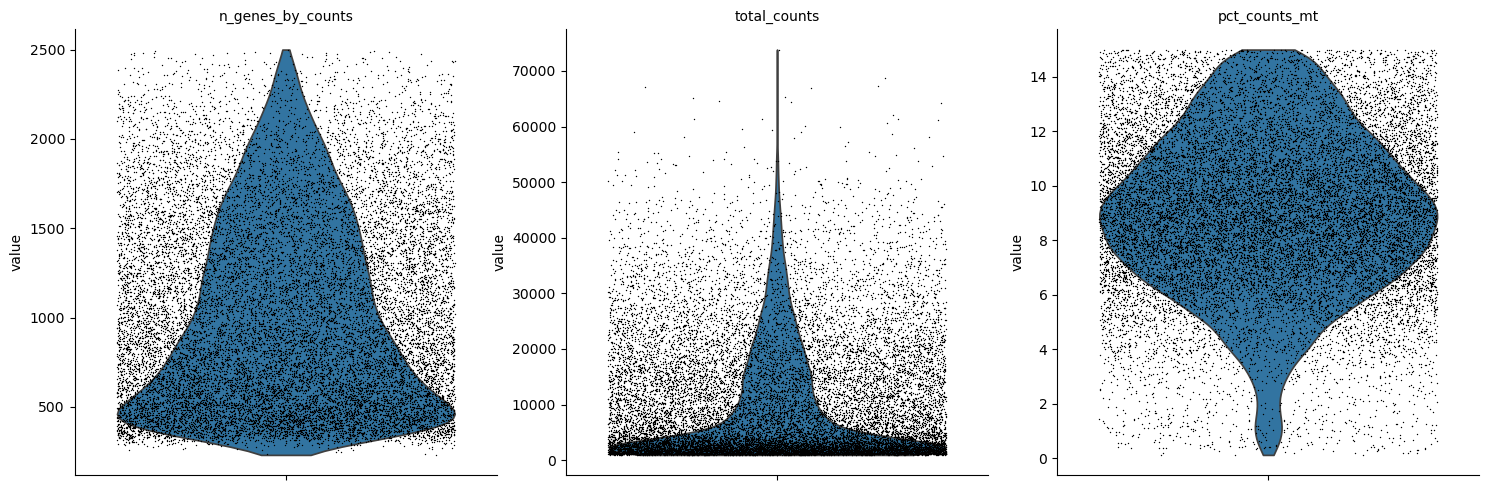

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## normalization and peak find variable genes

In [7]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)

adata

ImportError: Please install skmisc package via `pip install --user scikit-misc

In [7]:
# save data
adata.write("1.before_integrate.h5ad")

# Intergrate data by Harmonoy

In [2]:
# read in data
adata = sc.read('./1.before_integrate.h5ad')
adata

AnnData object with n_obs × n_vars = 19285 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [4]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2025-04-08 10:29:17,926 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-08 10:29:27,921 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-08 10:29:28,222 - harmonypy - INFO - Iteration 1 of 10
2025-04-08 10:29:38,038 - harmonypy - INFO - Iteration 2 of 10
2025-04-08 10:29:48,146 - harmonypy - INFO - Iteration 3 of 10
2025-04-08 10:29:57,251 - harmonypy - INFO - Iteration 4 of 10
2025-04-08 10:30:06,900 - harmonypy - INFO - Iteration 5 of 10
2025-04-08 10:30:16,237 - harmonypy - INFO - Iteration 6 of 10
2025-04-08 10:30:22,183 - harmonypy - INFO - Iteration 7 of 1

In [5]:
adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

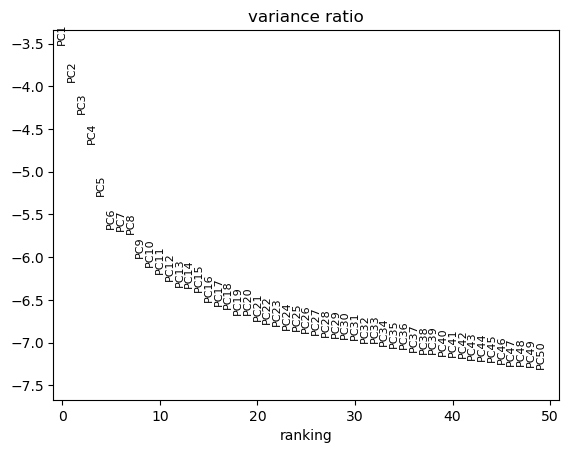

In [6]:
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

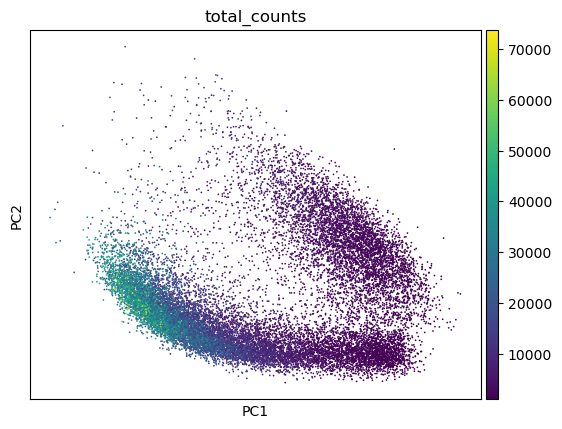

In [7]:
sc.pl.pca_scatter(adata, color="total_counts")

In [8]:
# save data
adata.write("2.integrated.h5ad")
# show Anndata
adata

AnnData object with n_obs × n_vars = 19285 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw'
    varm: 'PCs'

# clustering

In [9]:
adata = sc.read("2.integrated.h5ad")
adata

AnnData object with n_obs × n_vars = 19285 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw'
    varm: 'PCs'

## plot UMAP

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_6979/117608690.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


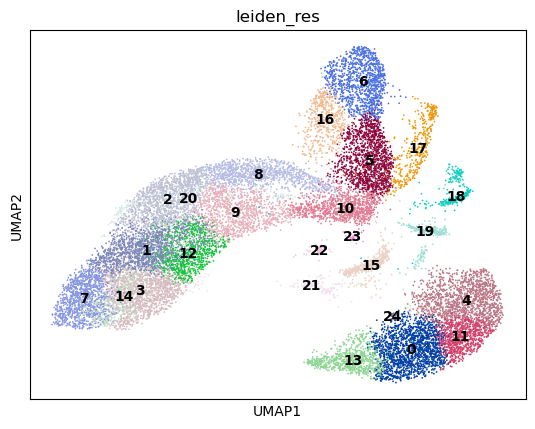

In [10]:
adata = sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.5,
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.8,
)

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [11]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     1635
1     1464
2     1436
3     1399
4     1362
5     1320
6     1096
7     1079
8     1074
9     1033
10     953
11     864
12     821
13     768
14     578
15     467
16     457
17     401
18     284
19     241
20     225
21     203
22      58
23      43
24      24
Name: count, dtype: int64

In [12]:
# save data
adata.write("3.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 19285 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./3.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 19285 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

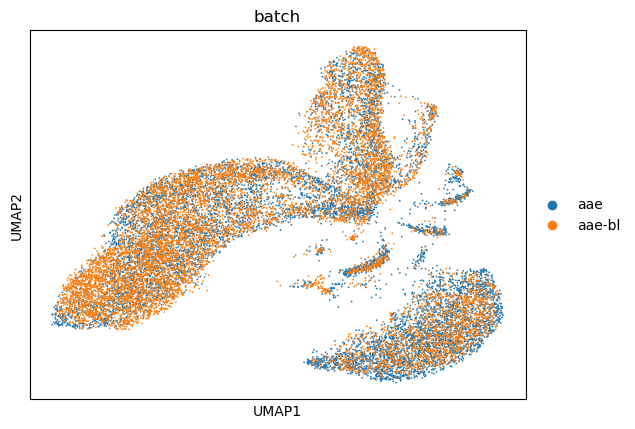

In [3]:
sc.pl.umap(
    adata,
    color=["batch"],
)

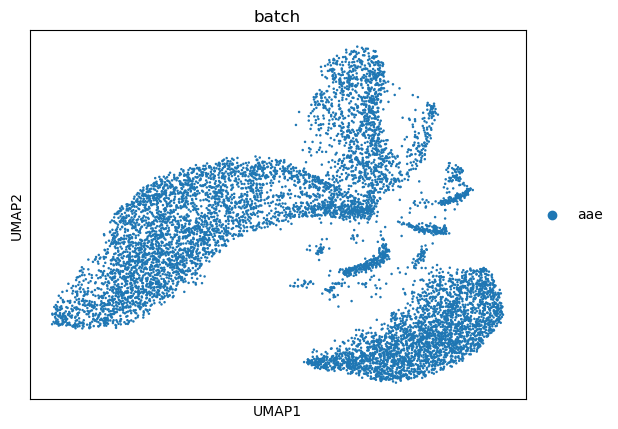

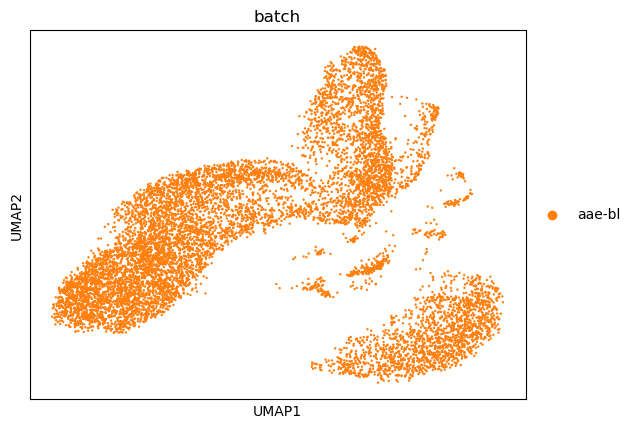

In [4]:
for i in ['aae', 'aae-bl']:
    sc.pl.umap(adata[adata.obs['batch'] == i], color=["batch"])

In [3]:
# 'LOC5563695': 'fibulin-1'
marker_genes = {
    'ISC/EB': ['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC110676293', 'LOC5580247'], # Klu, Delta, esg
    'Cardia': ['LOC5564993', 'LOC5579458'], # GAM1, LYZ1 ['LOC5568253', 'LOC5572257'] FCN3, CTRB2
    'EC': ['LOC23687865', 'LOC5573855'], # Nub, CPA-VII
    'EC-like': ['LOC5571803', 'LOC5574806', 'LOC5570613'], # CAH7, Cht10, SNAT1, LYZL
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874', 'LOC5565599'], # prospero, npf, orcokinin, Calexcitin-1
    'VM':['LOC5571832'], # actin
    # 'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
    # 'SV-2/UNC93': ['LOC5579856', 'LOC5564054']
}

In [4]:
g_n = {k: v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5579856', 'LOC5564054', 'LOC5565599', 'LOC5580247'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'NAAT', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'SV-2', 'UNC93', 'CCHa2', 'PCNA'])
}
g_n

{'LOC5563695': 'fibulin-1',
 'LOC5578162': 'Klu',
 'LOC5580156': 'Delta',
 'LOC5570443': 'esg',
 'LOC5564993': 'GAM1',
 'LOC5579458': 'LYSC',
 'LOC23687865': 'Nubbin',
 'LOC5573855': 'CPA-VII',
 'LOC5571803': 'CAH7',
 'LOC5574806': 'Cht10',
 'LOC5570613': 'NAAT',
 'LOC110676293': 'LYSC11',
 'LOC5575988': 'prospero',
 'LOC5569132': 'npf',
 'LOC5575886': 'orcokinin',
 'LOC5573874': 'Calexcitin-1',
 'LOC5571832': 'actin',
 'LOC5571084': 'apolipophorin-3',
 'LOC5570883': 'LRIM16',
 'LOC110674010': 'NimB2',
 'LOC5579856': 'SV-2',
 'LOC5564054': 'UNC93',
 'LOC5565599': 'CCHa2',
 'LOC5580247': 'PCNA'}

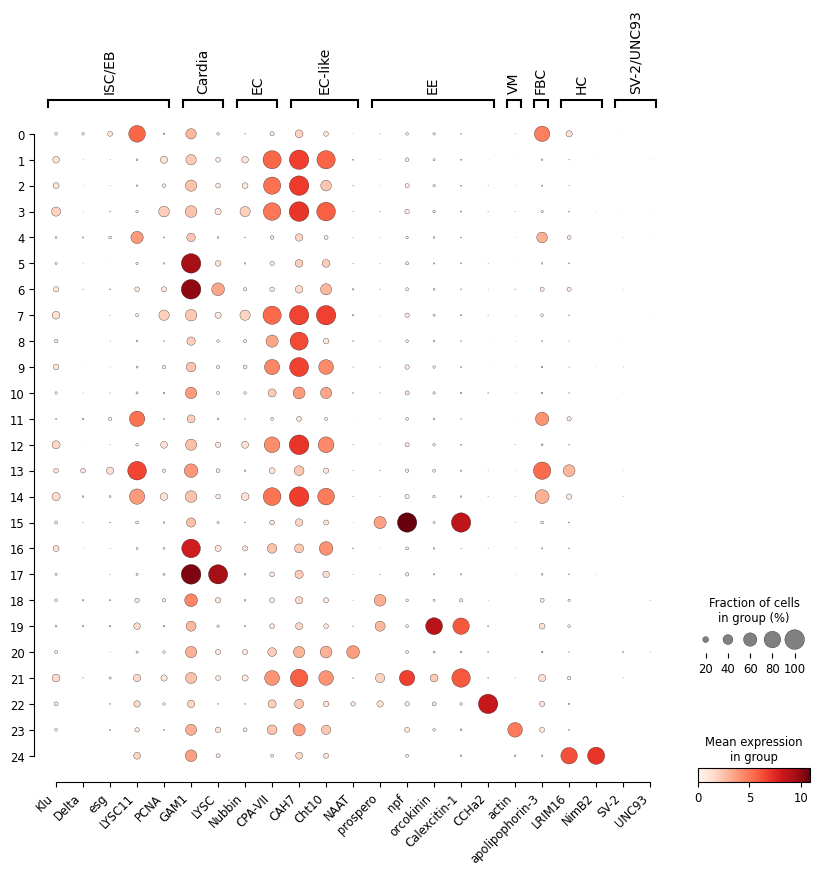

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [5]:
n_id = {
    'ISC/EB': ['11', '4'],
    'ISC/EB-prol': ['0', '13'],
    'Cardia-1': ['17'],
    'Cardia-2': ['6', '5', '16'],
    'EC': ['3', '7', '14', '1', '12'],
    'EC-like-1': ['2', '8', '9'],
    'EC-like-2': ['10'],
    'EC-like-3': ['20'],
    'EE-1': ['15', '21'],
    'EE-2': ['19'],
    'EE-3': ['18'],
    'EE-4': ['22'],
    'VM': ['23'],
    # 'FBC': ['27'],
    'HC': ['24'],
    # 'SV-2/UNC93': ['25'],
}

In [6]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'11': 'ISC/EB',
 '4': 'ISC/EB',
 '0': 'ISC/EB-prol',
 '13': 'ISC/EB-prol',
 '17': 'Cardia-1',
 '6': 'Cardia-2',
 '5': 'Cardia-2',
 '16': 'Cardia-2',
 '3': 'EC',
 '7': 'EC',
 '14': 'EC',
 '1': 'EC',
 '12': 'EC',
 '2': 'EC-like-1',
 '8': 'EC-like-1',
 '9': 'EC-like-1',
 '10': 'EC-like-2',
 '20': 'EC-like-3',
 '15': 'EE-1',
 '21': 'EE-1',
 '19': 'EE-2',
 '18': 'EE-3',
 '22': 'EE-4',
 '23': 'VM',
 '24': 'HC'}

In [15]:
sorted([int(i) for i in id_n.keys()])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [7]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [8]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()))

adata.obs['cluster_name'].unique()

['ISC/EB', 'EC-like-2', 'EC', 'ISC/EB-prol', 'Cardia-2', ..., 'EE-2', 'EC-like-3', 'EE-4', 'HC', 'VM']
Length: 14
Categories (14, object): ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', ..., 'EE-3', 'EE-4', 'VM', 'HC']

In [9]:
adata.write('./4.ann.h5ad')

In [12]:
adata.obs['batch'].unique()

['aae', 'aae-bl']
Categories (2, object): ['aae', 'aae-bl']

In [9]:
dp = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.aae-aaebl.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.aae-aaebl.csv')

In [10]:
dp = sc.pl.dotplot(
    adata[adata.obs['batch'] == 'aae-bl'],
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.aaebl.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.aaebl.csv')

In [11]:
dp = sc.pl.dotplot(
    adata[adata.obs['batch'] == 'aae'],
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.aae.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.aae.csv')

In [17]:
g_n

{'LOC5578162': 'Klu',
 'LOC5580156': 'Delta',
 'LOC5570443': 'esg',
 'LOC5564993': 'GAM1',
 'LOC5579458': 'LYSC',
 'LOC23687865': 'Nubbin',
 'LOC5573855': 'CPA-VII',
 'LOC5571803': 'CAH7',
 'LOC5574806': 'Cht10',
 'LOC5570613': 'NAAT',
 'LOC110676293': 'LYSC11',
 'LOC5575988': 'prospero',
 'LOC5569132': 'npf',
 'LOC5575886': 'orcokinin',
 'LOC5573874': 'Calexcitin-1',
 'LOC5571832': 'actin',
 'LOC5571084': 'apolipophorin-3',
 'LOC5570883': 'LRIM16',
 'LOC110674010': 'NimB2',
 'LOC5579856': 'SV-2',
 'LOC5564054': 'UNC93',
 'LOC5565599': 'CCHa2',
 'LOC5580247': 'PCNA'}

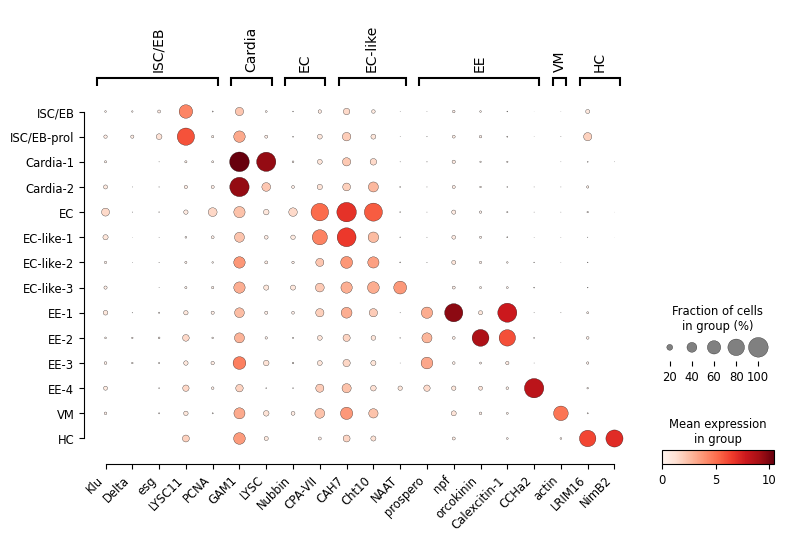

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

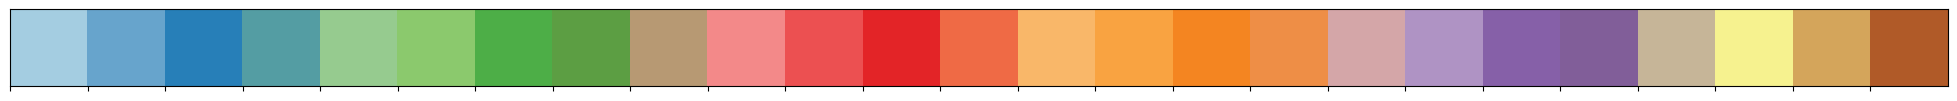

In [11]:
rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]

sns.palplot(rc)

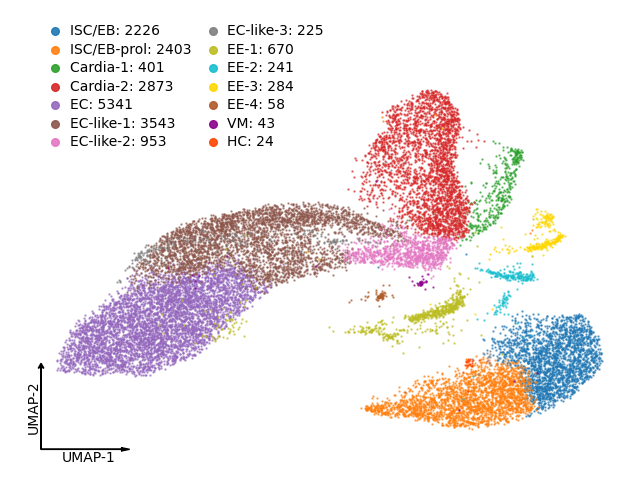

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('aaebl_umap.pdf', bbox_inches='tight')
# plt.close()

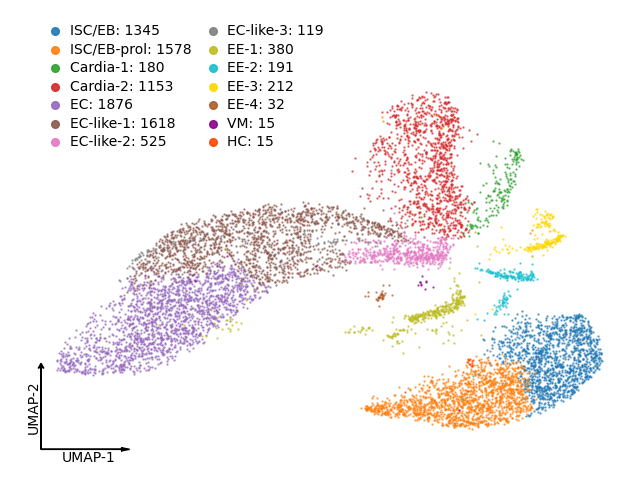

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'aae']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('aaebl_umap.pdf', bbox_inches='tight')
# plt.close()

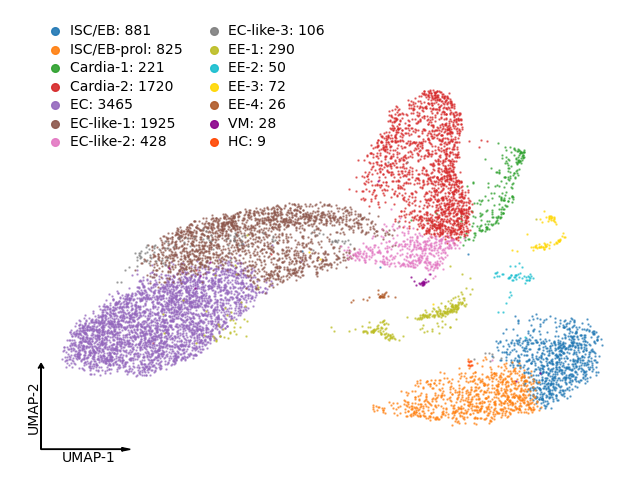

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'aae-bl']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('aaebl_umap.pdf', bbox_inches='tight')
# plt.close()

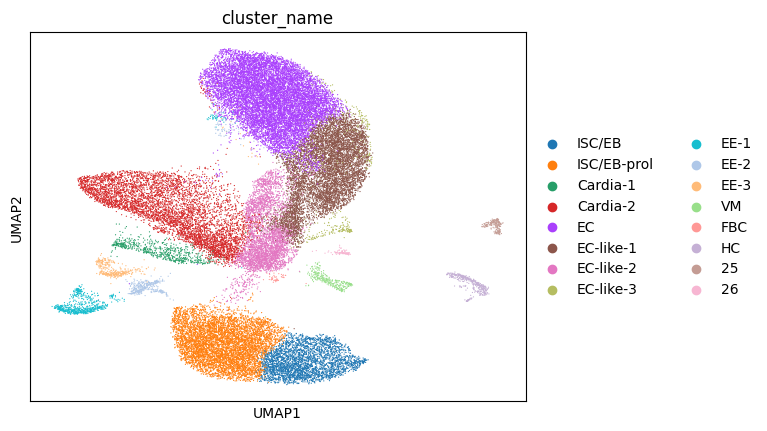

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sc.pl.umap(
    adata,
    color=["cluster_name"],
)

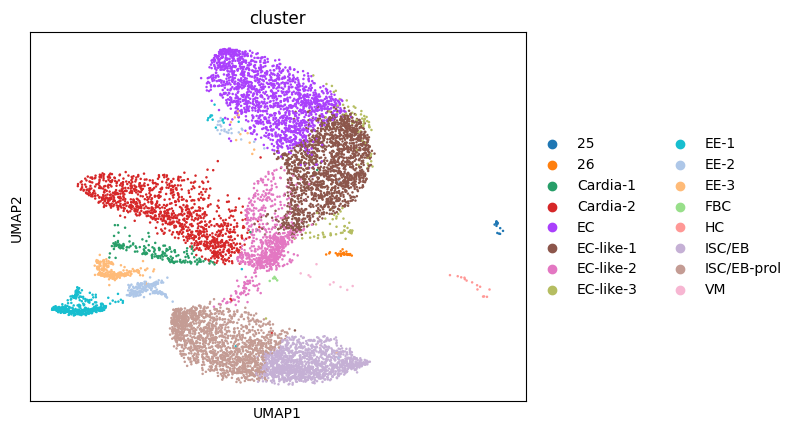

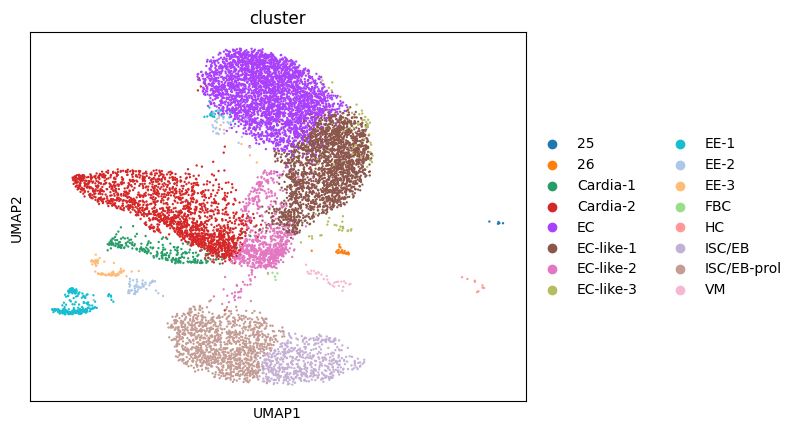

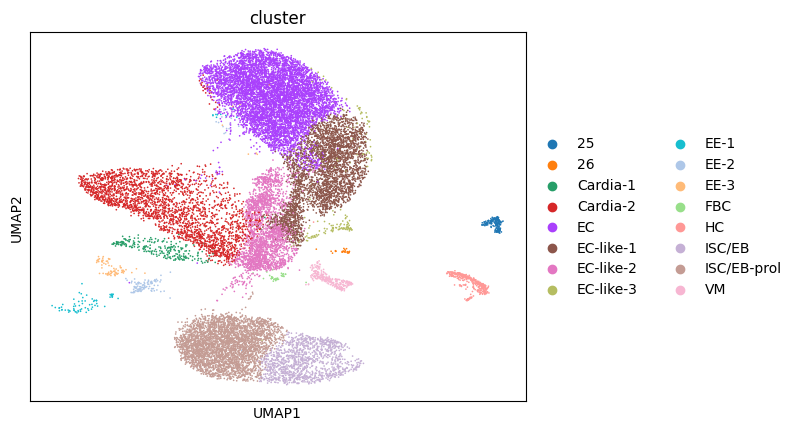

In [77]:
for i in ['aae', 'aae-bl', 'aae-dv']:
    sc.pl.umap(adata[adata.obs['batch'] == i], color=["cluster"])

In [16]:
adata.write('./4.ann.h5ad')

In [4]:
adata = sc.read('./4.ann.h5ad')
adata

AnnData object with n_obs × n_vars = 40350 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res', 'cluster', 'cluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
pdf = adata.obs[['batch', 'cluster_name']].value_counts().reset_index()

def sum_ct(df):
    df['sum'] = df['count'].sum()
    df['cellular percentage (%)'] = df['count'] / df['sum'] * 100
    df['cellular percentage (%)'] = df['cellular percentage (%)'].map(lambda x: round(x, 2))
    return df    

pdf = pdf.groupby(['batch']).apply(sum_ct)
pdf

/tmp/ipykernel_676/761387135.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdf = pdf.groupby(['batch']).apply(sum_ct)
/tmp/ipykernel_676/761387135.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pdf = pdf.groupby(['batch']).apply(sum_ct)


batch cluster_name  count    sum  cellular percentage (%)
batch                                                                
aae    8      aae    EC-like-1   1686   9218                    18.29
       9      aae           EC   1654   9218                    17.94
       10     aae       ISC/EB   1566   9218                    16.99
       11     aae  ISC/EB-prol   1331   9218                    14.44
       14     aae     Cardia-2   1100   9218                    11.93
       16     aae    EC-like-2    722   9218                     7.83
       19     aae         EE-1    360   9218                     3.91
       24     aae         EE-3    228   9218                     2.47
       25     aae         EE-2    215   9218                     2.33
       26     aae     Cardia-1    171   9218                     1.86
       30     aae    EC-like-3    106   9218                     1.15
       37     aae         EE-4     34   9218                     0.37
       41     aae   SV-2/UNC93     15   9218                     0.16
       42     aae           HC     14   9218                     0.15
       43     aae           VM     10   9218                     0.11
       45     aae          FBC      6   9218                     0.07
aae-bl 2   aae-bl           EC   3221  10551                    30.53
       6   aae-bl    EC-like-1   2167  10551                    20.54
       7   aae-bl     Cardia-2   1844  10551                    17.48
       13  aae-bl       ISC/EB   1139  10551                    10.80
       15  aae-bl    EC-like-2    783  10551                     7.42
       17  aae-bl  ISC/EB-prol    559  10551                     5.30
       20  aae-bl         EE-1    260  10551                     2.46
       23  aae-bl     Cardia-1    236  10551                     2.24
       31  aae-bl    EC-like-3     96  10551                     0.91
       32  aae-bl         EE-2     90  10551                     0.85
       35  aae-bl         EE-3     75  10551                     0.71
       38  aae-bl           VM     32  10551                     0.30
       39  aae-bl         EE-4     30  10551                     0.28
       44  aae-bl           HC      9  10551                     0.09
       46  aae-bl   SV-2/UNC93      5  10551                     0.05
       47  aae-bl          FBC      5  10551                     0.05
aae-dv 0   aae-dv           EC   6502  20581                    31.59
       1   aae-dv       ISC/EB   3538  20581                    17.19
       3   aae-dv    EC-like-1   3060  20581                    14.87
       4   aae-dv     Cardia-2   2490  20581                    12.10
       5   aae-dv    EC-like-2   2238  20581                    10.87
       12  aae-dv  ISC/EB-prol   1218  20581                     5.92
       18  aae-dv           HC    367  20581                     1.78
       21  aae-dv           VM    260  20581                     1.26
       22  aae-dv     Cardia-1    240  20581                     1.17
       27  aae-dv   SV-2/UNC93    171  20581                     0.83
       28  aae-dv    EC-like-3    168  20581                     0.82
       29  aae-dv         EE-2    115  20581                     0.56
       33  aae-dv         EE-1     78  20581                     0.38
       34  aae-dv         EE-3     76  20581                     0.37
       36  aae-dv          FBC     35  20581                     0.17
       40  aae-dv         EE-4     25  20581                     0.12

In [5]:
pdf[(pdf['batch'] == 'aae-dv') & (pdf['cluster_name'] == 'a')].empty

True

In [10]:
def get_val(df, conditon, cell):
    cell_sum = int(df[(df['batch'] == conditon)]['sum'].iloc[0])
    tmp_df = df[(df['batch'] == conditon) & (df['cluster_name'] == cell)]
    if tmp_df.empty:
        return 0, cell_sum
    else:
        cell_num = int(tmp_df['count'].values)
        return cell_num, cell_sum - cell_num

df_fisher = deque()
for cell in pdf['cluster_name'].unique():
    v1c1, v1c0 = get_val(pdf, 'aae-dv', cell)
    v0c1, v0c0 = get_val(pdf, 'aae-bl', cell)
    table = [[v1c1, v1c0], [v0c1, v0c0]]
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
    df_fisher.append([cell, 'aae-dv', 'aae-bl', odds_ratio, p_value])

df_fisher = pd.DataFrame(df_fisher, columns=['cell', 'condition1', 'condition2', 'odds_ratio', 'p_value'])
df_fisher

/tmp/ipykernel_28726/3161246067.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_num = int(tmp_df['count'].values)


,cell,condition1,condition2,odds_ratio,p_value
0,EC-like-1,aae-dv,aae-bl,0.675702,7.211261e-36
1,EC,aae-dv,aae-bl,1.050965,5.589078e-02
2,ISC/EB,aae-dv,aae-bl,1.715418,9.708780e-53
3,ISC/EB-prol,aae-dv,aae-bl,1.124386,2.644183e-02
4,Cardia-2,aae-dv,aae-bl,0.649897,2.112647e-37
5,EC-like-2,aae-dv,aae-bl,1.522066,2.989336e-23
6,EE-1,aae-dv,aae-bl,0.150578,2.869618e-59
7,EE-3,aae-dv,aae-bl,0.517712,6.539096e-05
8,EE-2,aae-dv,aae-bl,0.653124,2.988550e-03
9,Cardia-1,aae-dv,aae-bl,0.515699,1.356577e-12


/tmp/ipykernel_31950/3263987851.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_31950/3263987851.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
/tmp/ipykernel_31950/3263987851.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])


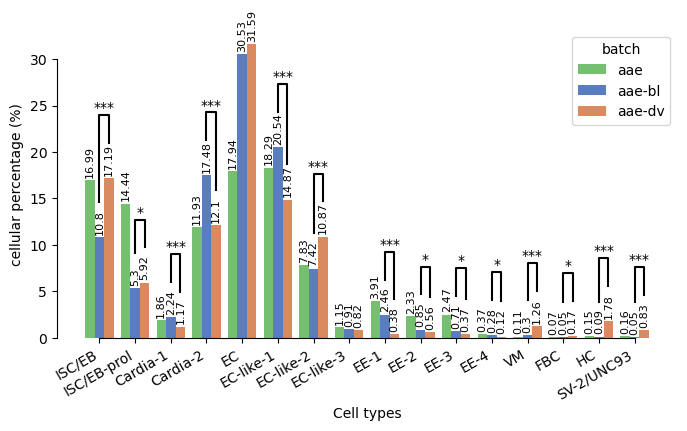

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

ax = sns.barplot(
    pdf,
    y='cellular percentage (%)',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell types')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

# plot sig
for i, cell in enumerate(ax.get_xticklabels()):
    cell = cell.get_text()
    if cell in list(df_fisher['cell']):
        ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
        pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])
        if pval <= 0.05:
            start_bar = ax.patches[16 + i]
            end_bar = ax.patches[32 + i]
            # x
            start_x = start_bar.get_x() + start_bar.get_width() / 2
            end_x = end_bar.get_x() + end_bar.get_width() / 2
            # y
            bia = 3.8
            start_y = start_bar.get_y() + start_bar.get_height() + bia
            end_y = end_bar.get_y() + end_bar.get_height() + bia

            symbol = '***' if pval <= 1e-10 else '*'
            symbol_x = (start_x + end_x) / 2
            symbol_y = max(start_y, end_y) + 3
            ax.text(symbol_x, symbol_y, symbol, ha='center', va='bottom')

            # plot
            ax.plot(
                (start_x, start_x, end_x, end_x),
                (start_y, symbol_y, symbol_y, end_y),
                'k-'
            )

sns.despine(top=True, right=True, trim=3, ax=ax)

In [102]:
end_y

np.int64(0)

In [99]:
ax.patches[32].get_x()

np.float64(0.13333333333333328)

/tmp/user/1001/ipykernel_102816/3196642468.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


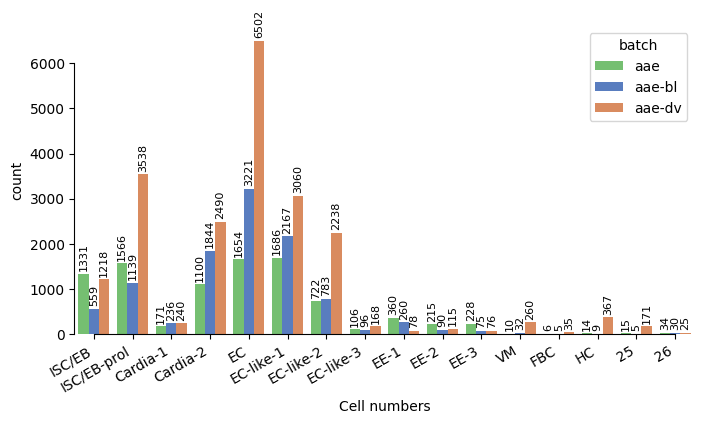

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

sns.barplot(
    pdf,
    y='count',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell numbers')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

sns.despine(top=True, right=True, trim=3, ax=ax)

# plot pdf

In [42]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

plt.savefig('aaebl_merge.dotplot.pdf', bbox_inches='tight')
plt.close()

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('aaebl_merge.umap.pdf', bbox_inches='tight')
plt.close()

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'aae']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('aaebl_merge.aae.umap.pdf', bbox_inches='tight')
plt.close()

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'aae-bl']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#b05a28", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'EE-4', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1; y = -3.8

ax.arrow(
    x-6.5, y-3, 0, 4.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-0.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = -5; y = 18
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5.5, y - (i % sep) * 1.1, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5.5 + 0.5, y - (i % sep) * 1.1, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('aaebl_merge.aaebl.umap.pdf', bbox_inches='tight')
plt.close()

In [89]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

matplotlib.use('cairo')

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

ax = sns.barplot(
    pdf,
    y='cellular percentage (%)',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell types')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

# plot sig
for i, cell in enumerate(ax.get_xticklabels()):
    cell = cell.get_text()
    if cell in list(df_fisher['cell']):
        ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
        pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])
        if pval <= 0.05:
            start_bar = ax.patches[16 + i]
            end_bar = ax.patches[32 + i]
            # x
            start_x = start_bar.get_x() + start_bar.get_width() / 2
            end_x = end_bar.get_x() + end_bar.get_width() / 2
            # y
            bia = 3.8
            start_y = start_bar.get_y() + start_bar.get_height() + bia
            end_y = end_bar.get_y() + end_bar.get_height() + bia

            symbol = '***' if pval <= 1e-10 else '*'
            symbol_x = (start_x + end_x) / 2
            symbol_y = max(start_y, end_y) + 3
            ax.text(symbol_x, symbol_y, symbol, ha='center', va='bottom')

            # plot
            ax.plot(
                (start_x, start_x, end_x, end_x),
                (start_y, symbol_y, symbol_y, end_y),
                'k-'
            )

sns.despine(top=True, right=True, trim=3, ax=ax)

plt.savefig('aaedv_barplot.pdf', bbox_inches='tight')
plt.close()

/tmp/ipykernel_27893/2127285054.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_27893/2127285054.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
/tmp/ipykernel_27893/2127285054.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])


In [7]:
adata = sc.read('./4.ann.h5ad')
adata.obs['batch']

CGATCGGTA_AACGTCCAA_AACAAGTGG-aae       aae
CGCCAATGA_AACGTCCAA_AACAAGTGG-aae       aae
TGCCTGATC_AACGTCCAA_AACAAGTGG-aae       aae
GAGCAGCTT_ACACCAACG_AACAAGTGG-aae       aae
TCCGTATCA_ACACCAACG_AACAAGTGG-aae       aae
                                      ...  
AGCTCCTTG_TGGACTTGT_TTGTGTACG-bl     aae-bl
CTTGACGTT_TGGACTTGT_TTGTGTACG-bl     aae-bl
AGTTCAGAG_TGGTCAGTT_TTGTGTACG-bl     aae-bl
CTCAGAACT_TTCCAATCG_TTGTGTACG-bl     aae-bl
AGGAGCAAT_TTGGTGACC_TTGTGTACG-bl     aae-bl
Name: batch, Length: 19285, dtype: category
Categories (2, object): ['aae', 'aae-bl']

In [6]:
adata = sc.read('./4.ann.h5ad')

adata = adata[adata.obs['batch'] == 'aae']
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./4.marker_genes.aae.csv')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [7]:
adata = sc.read('./4.ann.h5ad')

adata = adata[adata.obs['batch'] == 'aae-bl']
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
    min_in_group_fraction=0,
    min_fold_change=0,
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./4.marker_genes.aaebl.csv')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [3]:
adata = sc.read('./4.ann.h5ad')

# write umap plot data
umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

umap_lb = pd.concat([umap, adata.obs[['batch', 'cluster_name']]], axis=1)
umap_lb.index.name = 'barcode'

umap_lb.to_csv('4.umap_lb.aae-aaebl.csv')